# Advanced machine learning - Task 3

While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

In [1]:
import numpy as np
import pandas as pd
import pywt
import sklearn
import matplotlib.pyplot as plt
import biosppy
from sklearn.preprocessing import normalize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

In [2]:
X_train_df = pd.read_csv("X_train.csv", index_col='id')
y_train_df = pd.read_csv("y_train.csv", index_col='id')
y_train_df = y_train_df.to_numpy()
X_test_df = pd.read_csv("X_test.csv", index_col='id')

In [3]:
X_train_df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
count,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
mean,6.382842,5.607387,5.115888,4.909713,5.092828,5.723471,6.469220,7.278483,8.176471,9.098886,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN
std,339.371828,337.717355,336.734976,337.096437,338.294857,340.230604,342.761518,345.464582,348.134195,351.312129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-5888.000000,-5849.000000,-5750.000000,-5638.000000,-5515.000000,-5379.000000,-5233.000000,-5168.000000,-5760.000000,-6279.000000,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN
25%,-89.000000,-89.000000,-89.000000,-89.000000,-87.000000,-87.000000,-85.000000,-85.000000,-86.000000,-86.000000,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN
50%,-9.000000,-10.000000,-11.000000,-10.000000,-10.000000,-10.000000,-9.000000,-8.000000,-8.000000,-8.000000,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN
75%,88.000000,86.000000,86.000000,85.000000,87.000000,87.000000,87.000000,87.000000,87.000000,86.000000,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN
max,5471.000000,5487.000000,5470.000000,5452.000000,5437.000000,5432.000000,5431.000000,5429.000000,5427.000000,5410.000000,...,-121.0,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN


In [4]:
X_test_df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
count,3411.00000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3.04808,2.534741,2.179420,1.850191,1.758135,1.567869,1.339197,1.150982,0.745529,0.233949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,348.66225,349.111943,350.413328,351.938566,352.962295,353.457038,353.036545,351.921339,350.292242,348.996013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-4146.00000,-4193.000000,-4225.000000,-4253.000000,-4273.000000,-4285.000000,-4292.000000,-4297.000000,-4301.000000,-4301.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-87.50000,-87.000000,-88.000000,-87.000000,-88.000000,-87.000000,-87.000000,-87.000000,-88.000000,-87.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-10.00000,-11.000000,-10.000000,-10.000000,-9.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,85.50000,84.500000,84.000000,82.000000,81.000000,82.000000,83.000000,83.000000,84.000000,83.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,3734.00000,3598.000000,3453.000000,3306.000000,3167.000000,3038.000000,2926.000000,2933.000000,3112.000000,3255.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define necessary functions

In [5]:
def remove_starting_period(data):
    start = 700
    data = data.drop(data.columns[range(start)], axis=1)
    return data

def check_flipped_ecg(data):
    a = (np.max(data, axis=1) <= -0.75*np.min(data, axis=1))
    idx = np.where(a)[0]
    data.loc[idx,:] = - data.loc[idx,:]
    return data

def extract_peaks_intervals(tmpl):
    norm_tmpl = normalize(tmpl)
    wave = np.array(sum(norm_tmpl) / len(norm_tmpl))
    idx = np.where(wave == np.max(wave))
    R_location = idx[0][0]
    before_R = wave[:R_location]
    Q_location = np.where(wave == np.min(before_R[R_location-35:R_location]))
    Q_location = Q_location[0][0]
    P_location = np.where(before_R[0:Q_location] == np.max(before_R[0:Q_location]))
    P_location = P_location[0][0]
    after_R = wave[R_location:]
    S_location = np.where(wave == np.min(after_R[:25]))[0][0]
    T_location = np.where(wave == np.max(after_R[S_location-R_location+1:]))[0][0]

    PR_interval = R_location - P_location
    QRS_interval = S_location - Q_location
    ST_interval = T_location - S_location
    
    return R_location, Q_location, P_location, S_location, T_location, PR_interval, QRS_interval, ST_interval, np.ptp(wave), np.average(wave)

def features(data):
    num_row = data.shape[0]
    num_col = 118  # num of features defined below
      
    output = np.empty((num_row, num_col))
    
    for i in range(num_row):
        # extract ecg information
        idx = np.isfinite(data.loc[i,:])
        ecg_output = biosppy.signals.ecg.ecg(data.loc[i,idx],sampling_rate=300, show=False)
        
        # rpeaks => 5 features
        rpeaks = ecg_output['rpeaks']
        # relative to number of observations
        output[i,0] = rpeaks.shape[0] / np.sum(idx==True)
        #average and std of delta betweeen rpeaks
        output[i,1] = np.mean(np.diff(rpeaks))   
        output[i,2] = np.std(np.diff(rpeaks))        
        output[i,3] = np.quantile(np.diff(rpeaks),0.05) 
        output[i,4] = np.quantile(np.diff(rpeaks),0.95)
        
        # heart rate => 7 features
        hr = ecg_output['heart_rate']
        if hr.shape[0] != 0:
            output[i,5] = np.min(hr)
            output[i,6] = np.max(hr)
            output[i,7] = np.quantile(hr, 0.05)
            output[i,8] = np.quantile(hr, 0.95)
            output[i,9] = np.std(hr)
            output[i,10] = np.std(hr)
        else:
            output[i,5:11] = float("nan")
            
        # templates => 
        tmpl = ecg_output['templates']
        # median, mean and std across templates (rows) for each time point (col)
        data_mean = np.mean(tmpl, axis=0)
        data_median = np.median(tmpl, axis=0)
        data_std = np.std(tmpl, axis=0)
        data_max = np.max(tmpl, axis=0)
        data_min = np.min(tmpl, axis=0)
        output[i,11] = np.mean(np.abs(data_mean - data_median))
        output[i,12] = np.mean(np.abs(data_max))
        output[i,13] = np.mean(np.abs(data_min))
        output[i,14] = np.mean(data_std)
        output[i,15] = output[i, 14] / output[i, 12]  # like a normalized volatility (peak=1)
        
        # wavelet transform
        cA, cD = pywt.dwt(ecg_output['templates'], 'db2')
        # calc stats per bucket (covering 20pts)
        k=16
        for j in range(9):
            idx = range(j*10,(j+1)*10)
            data_mean = np.mean(cD[:,idx], axis=0)
            data_median = np.median(cD[:,idx], axis=0)
            data_std = np.std(cD[:,idx], axis=0)
            data_max = np.max(cD[:,idx], axis=0)
            data_min = np.min(cD[:,idx], axis=0)
            output[i,k] = np.mean(data_median)
            output[i,k+1] = np.mean(data_max)
            output[i,k+2] = np.mean(data_min)
            output[i,k+3] = np.mean(data_mean)   
            output[i,k+4] = np.mean(data_std)       
            # same with data normalized by peak value
            data_mean = np.mean(cA[:,idx], axis=0)
            data_median = np.median(cA[:,idx], axis=0)
            data_std = np.std(cA[:,idx], axis=0)
            data_max = np.max(cA[:,idx], axis=0)
            data_min = np.min(cA[:,idx], axis=0)
            output[i,k+5] = np.mean(data_median)
            output[i,k+6] = np.mean(data_max)
            output[i,k+7] = np.mean(data_min)
            output[i,k+8] = np.mean(data_mean)   
            output[i,k+9] = np.mean(data_std)               
            k = k+10
            
        
        # add R, Q, P, S, T and their intervals
        peaks_intervals = extract_peaks_intervals(tmpl)
        for feature in peaks_intervals:
            output[i, k] = feature
            k += 1
            
        # ptp = np.ptp(data.loc[i,idx])
        # avg = np.avg(data.loc[i,idx])
        # output[i, k] = ptp
        # output[i, k+1] = avg
        
            
        if i % 500 == 0:
            print(i)
            
    col_mean = np.nanmean(output, axis=0)
    idx = np.where(np.isnan(output))
    print('Nr of NaNs: ', idx[1].shape[0])
    print(idx)
    output[idx] = np.take(col_mean, idx[1])
    
    return output

def process_data(data):
    data = remove_starting_period(data)
    data = check_flipped_ecg(data)
    return features(data)
    



## Extracting peaks and intervals

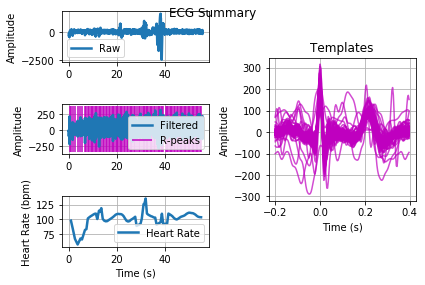

In [6]:
i = 100
idx = np.isfinite(X_train_df.loc[i,:])
a = biosppy.signals.ecg.ecg(X_train_df.loc[i,idx], sampling_rate=300)


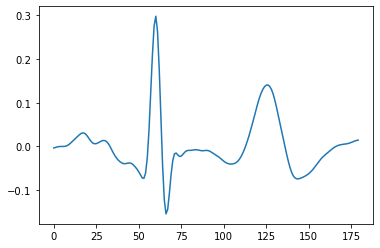

In [7]:
norm_tmpl = normalize(a["templates"])
wave = np.array(sum(norm_tmpl) / len(norm_tmpl))
plt.plot(wave)

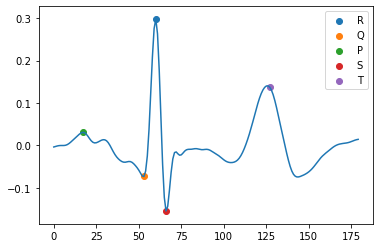

In [8]:
idx = np.where(wave == np.max(wave))
R_location = idx[0][0]
before_R = wave[:R_location]
Q_location = np.where(wave == np.min(before_R[R_location-35:R_location]))
Q_location = Q_location[0][0]
P_location = np.where(before_R[0:Q_location] == np.max(before_R[0:Q_location]))
P_location = P_location[0][0]
after_R = wave[R_location:]
S_location = np.where(wave == np.min(after_R[:25]))[0][0]
T_location = np.where(wave == np.max(after_R[S_location+1:]))[0][0]

PR_interval = R_location - P_location
QRS_interval = S_location - Q_location
ST_interval = T_location - S_location

plt.plot(wave)
plt.scatter(R_location, wave[R_location], label='R')
plt.scatter(Q_location, wave[Q_location], label='Q')
plt.scatter(P_location, wave[P_location], label='P')
plt.scatter(S_location, wave[S_location], label='S')
plt.scatter(T_location, wave[T_location], label='T')
plt.legend()
plt.show()


## Training

In [10]:
# num_folds = 10
# kf = sklearn.model_selection.KFold(num_folds)
# lr = [0.01, 0.05, 0.1, 0.25, 0.5]
# n_estimators = [100, 250, 500, 750, 1000]
# max_depth = [5, 6, 7, 8, 9]
# avg_F1 = np.zeros(len(lr))
# conf_mat = np.zeros((4,4))
# for lr_i in lr:
#     for train_index, test_index in kf.split(train_data):
#         x_trn, y_trn = train_data[train_index], y_train_df[train_index]
#         x_tst, y_tst = train_data[test_index], y_train_df[test_index]
#         clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, max_depth=8, 
#                                     min_samples_split=50, min_samples_leaf=30,
#                                     max_features='sqrt', random_state=1, subsample=0.8)
#         clf.fit(x_trn, y_trn)
#         y_pred = clf.predict(x_tst)
#         avg_F1[idx] = avg_F1[idx] + f1_score(y_tst, y_pred, average='micro') / num_folds
#         conf_mat = conf_mat + confusion_matrix(y_tst, y_pred)/ num_folds
    
    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


IndexError: index 60 is out of bounds for axis 0 with size 5

## Prediction

In [20]:
def fit_model_and_pred(X_train, y_train, X_val, y_val, X_test):
    clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, max_depth=8, 
                                                      min_samples_split=50, min_samples_leaf=30,
                                                      max_features='sqrt', random_state=1, subsample=0.8)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    score = f1_score(y_val, y_val_pred, average='micro')  
    y_pred = clf.predict(X_test)

    return score, y_pred

def train_k_fold(X, y, X_test, fold_num=5):
    kf = sklearn.model_selection.KFold(fold_num)
    kf.get_n_splits(X)
    test_score = 0.0
    predictions = np.zeros(X_test.shape[0])
    
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        score, y_pred = fit_model_and_pred(X_train, y_train, X_val, y_val, X_test)

        print('The obtained validation f1 score is : ',score)
        test_score += score
    print("Validation score: %f"%(test_score/fold_num))

In [ ]:
train_data = process_data(X_train_df)
test_data = process_data(X_test_df)

In [21]:
train_k_fold(train_data, y_train_df, test_data)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.802734375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.810546875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.779296875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.8125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.8046875


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.8203125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.771484375


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.812133072407045


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.7945205479452053


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The obtained validation f1 score is :  0.7925636007827789
Validation score: 1.600156


In [13]:
predictions = clf.predict(test_data)

In [14]:
ids = np.arange(0, len(predictions))
output = pd.DataFrame({'id': ids,
                           'y': predictions})
output.to_csv("output.csv", index=False)